# Demo: DNN-Regressor based on Entity Embedding for categorical variables

In [1]:
import numpy as np
import pandas as pd
from demo_transform import MyTransform
from model import CategoricalDnn
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

### Load dataset
* Challenge: predicting guesthouse prices from various columns

In [2]:
csv_dir = "./demodata.csv"
df = pd.read_csv(csv_dir)

print("number of  columns: ", len(df.columns))
print("number of rows: ", len(df))
pd.set_option('display.max_columns', 100)
df.head()

number of  columns:  40
number of rows:  73181


,listing_id,host_since,host_id,picture_url,host_thumbnail_url,calendar_updated,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,smart_location,country_code,has_availability,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,73345,2016-09-05,09cd543d7ff94bd0,918781121f397557,076bd9e54df95623,17 months ago,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,t,House,Entire home/apt,4,1.0,2.0,2.0,Real Bed,NaN,549c,9b20,t,f,7827,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.08,19301.40
1,27814,2014-03-03,f60538450bd9297e,7cbf0883e639d363,f96b57e18d1073f3,3 days ago,within an hour,100%,NaN,f,4.0,4.0,"['email', 'phone', 'reviews']",t,f,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,7369,9b20,t,f,9b2d,t,f,strict_14_with_grace_period,f,f,4,0,2,2,3.27,16084.50
2,16918,2012-01-10,f8a1ee9b81fe5723,4686f38136a7fa81,0e2756604a8385db,7 months ago,NaN,NaN,NaN,f,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,t,Apartment,Entire home/apt,6,2.0,2.0,3.0,Real Bed,NaN,17a8,9b20,t,f,9b2d,f,f,moderate,f,f,1,1,0,0,0.27,26807.50
3,32243,2018-09-17,af9d35ea0aa40839,d25e8725ee5d3aa2,819d3fff6e00aaeb,7 weeks ago,within an hour,100%,NaN,t,1.0,1.0,"['phone', 'offline_government_id', 'selfie', '...",t,f,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,b523,9b20,t,f,9b2d,t,f,moderate,f,f,1,0,1,0,4.24,7506.10
4,4877,2013-03-08,5cc090234ddb5cd1,8d869dab9c6469e9,f6aaf37a8fd77b03,5 months ago,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,17a8,9b20,t,f,9b2d,f,f,moderate,f,f,1,0,1,0,0.09,12331.45


### Split dataset into train and validation dataset   /   Fit a pre-processing
* Fit a preprocessing instance with training data and preprocess the data
* Pre-processing instances are designed to avoid data leakage
* Output:
     - Explanatory variables: categorical variables that have been factorized in the first half and numerical variables in the second half
     - Objective variable: zscore normalized price

In [3]:
# avoiding data leakage
df_train, df_val = train_test_split(df, test_size=0.1, random_state=16)
trans = MyTransform(y_zscore=True)
X_train, y_train = trans.fit_transform(df_train, min_category_count=3)
X_val, y_val = trans.transform(df_val)

# # allowing data leakage
# trans = MyTransform(y_zscore=True)
# X, y = trans.fit_transform(df, min_category_count=3)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=16)

np.set_printoptions(threshold=10000)
print()
print("A sample from pre-processed train data: ")
print()
print(X_train[0, :])

category thresholded ( host_id ), dropped categories:  44809
category thresholded ( host_thumbnail_url ), dropped categories:  44708
category thresholded ( host_is_superhost ), dropped categories:  0
category thresholded ( host_identity_verified ), dropped categories:  0
category thresholded ( property_type ), dropped categories:  10
category thresholded ( room_type ), dropped categories:  0
category thresholded ( bed_type ), dropped categories:  0
category thresholded ( smart_location ), dropped categories:  370
category thresholded ( jurisdiction_names ), dropped categories:  10
category thresholded ( cancellation_policy ), dropped categories:  0

A sample from pre-processed train data: 

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.13304468 -0.4606909
 -0.59029123 -0.42490186 -0.33941794 -0.57173376 -0.07873137 -0.43154662
 -1.16035857 -0.16637515 -0.18440519 -0.16376764 -0.20551369  0.30627369
 -0.12675775 -0.3

### Define DataLoaders for applying to a DNN model

In [4]:
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()
y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

### Define DNN model
* Regressor with embedding layers for categorical variables

In [5]:
compression_factor = 1 / 4              # (dimension of embedded feature) = (number of dictionaries) * compression_factor
max_embedded_features = 120     # max dimension of embedded feature of each categorical variable
embedding_construction = []
total_embedded_features = 0
for uniques in trans.cols_information["categorical_uniques"]:
    target = int(uniques * compression_factor)
    if target < 2:
        target = 2
    elif target > max_embedded_features:
        target = max_embedded_features
    embedding_construction.append([uniques, target])
    total_embedded_features += target
total_features = total_embedded_features + trans.num_numerical

model = CategoricalDnn(categorical_dicts_to_dims=embedding_construction,
                                          num_numerical_features=trans.num_numerical,
                                          fc_layers_construction=[100, 70],
                                          dropout_probability=0.1)

print(model)

CategoricalDnn(
  (embedding_layer_list): ModuleList(
    (0): Sequential(
      (0): Embedding(2985, 120)
      (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Embedding(2981, 120)
      (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Embedding(3, 2)
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Embedding(3, 2)
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Embedding(35, 8)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Sequential(
      (0): Embedding(3, 2)
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): Sequential(
      (0): Embedding(5, 2)
      (1): BatchNor

### Define optimizer

In [6]:
optimizer = torch.optim.SGD(model.parameters(),
                                                   lr=0.005,
                                                   momentum=0.9,
                                                   weight_decay=0.0005)

### Define loss function
* Mean Squared Error with L2 regularization to suppress overlearning

In [7]:
class RegularizedMSELoss:
    def __init__(self, p=2, lam=0.0001):
        self.p = p
        self.lam = lam

    def __call__(self, y1, y2):
        reg = 0.
        for param in optimizer.param_groups[0]['params']:
            reg += (param.abs() ** self.p).sum()
        reg = torch.sqrt(reg) * self.lam / self.p
        return ((y1 - y2) ** 2).mean() + reg

    def evaluate(self, y1, y2):
        return ((y1 - y2) ** 2).mean()


criterion = RegularizedMSELoss()

### Training

In [8]:
# evaluating function for validation dataset
def evaluation(model, loader):
    predicted = None
    true_y = None
    model.eval()
    for i, (batch_test_x, batch_test_y) in enumerate(loader):
        batch_predicted = model(batch_test_x)
        batch_predicted = batch_predicted
        if i == 0:
            true_y = batch_test_y
            predicted = batch_predicted
        else:
            true_y = torch.cat([true_y, batch_test_y], axis=0)
            predicted = torch.cat([predicted, batch_predicted], axis=0)
    return criterion.evaluate(true_y, predicted), predicted, true_y


# learning rate scheduler
def lr_schedule(e):
    if e in [35, 55, 70]:
        print("lr updated")
        optimizer.param_groups[0]["lr"] *= 0.1


# training loop
epochs = 75
loss = torch.zeros(epochs, dtype=torch.float)
loss_temp2 = torch.zeros(train_loader.__len__())
loss_test = torch.zeros(epochs, dtype=torch.float)
model.train()
for epoch in np.arange(0, epochs):
    lr_schedule(epoch)
    for batch_loop, (batch_x, batch_y) in enumerate(train_loader):
        out = model(batch_x)
        loss_temp = criterion(out, batch_y)
        optimizer.zero_grad()
        loss_temp.backward()
        optimizer.step()
        loss_temp2[batch_loop] = loss_temp
    loss[epoch] = loss_temp2.mean()
    loss_test[epoch] = evaluation(model, val_loader)[0]
    model.train()
    if epoch % 5 == 0:
        print("epoch: ", epoch, ", train loss: ", float(loss[epoch]), end="")
        print(", val loss: ", float(loss_test[epoch]))

epoch:  0 , train loss:  0.6018354296684265, val loss:  0.40202614665031433
epoch:  5 , train loss:  0.46942654252052307, val loss:  0.39101123809814453
epoch:  10 , train loss:  0.43786776065826416, val loss:  0.343082070350647
epoch:  15 , train loss:  0.419941782951355, val loss:  0.3586246371269226
epoch:  20 , train loss:  0.4100790023803711, val loss:  0.35188934206962585
epoch:  25 , train loss:  0.3964173197746277, val loss:  0.352235347032547
epoch:  30 , train loss:  0.38663914799690247, val loss:  0.3480011224746704
lr updated
epoch:  35 , train loss:  0.35784682631492615, val loss:  0.34268468618392944
epoch:  40 , train loss:  0.3453561067581177, val loss:  0.3445743918418884
epoch:  45 , train loss:  0.340389221906662, val loss:  0.34238728880882263
epoch:  50 , train loss:  0.34097006916999817, val loss:  0.3426054120063782
lr updated
epoch:  55 , train loss:  0.3397121727466583, val loss:  0.33893436193466187
epoch:  60 , train loss:  0.33161818981170654, val loss:  0.3

### Plot result
* Show final loss of validation data
* Plot validation data predictions and correct answers
* (Loss seems to be greatly affected by outliers of the objective variable)

final val loss:  0.34496066


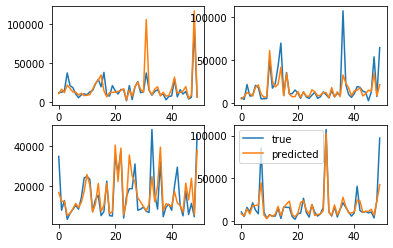

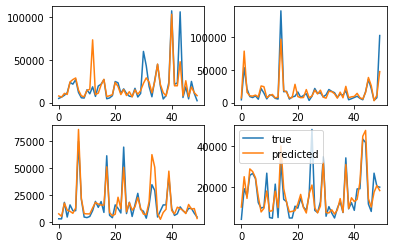

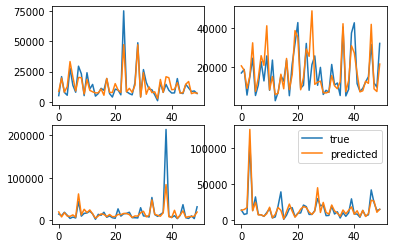

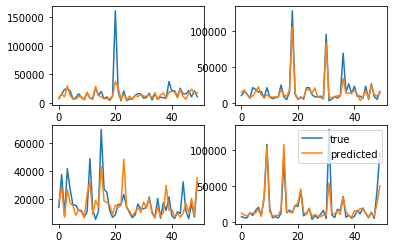

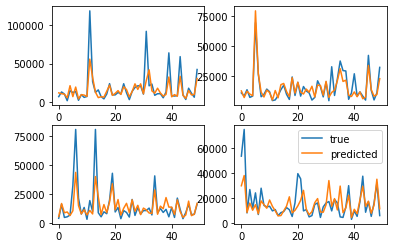

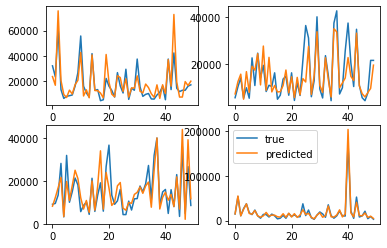

In [9]:
loss_test_final, predicted, true_y = evaluation(model, val_loader)
print("final val loss: ", loss_test_final.detach().numpy())

predicted = torch.clamp(predicted * trans.y_std + trans.y_mean, 0, None)
true_y = true_y * trans.y_std + trans.y_mean
predicted = predicted.squeeze().detach().numpy()
true_y = true_y.squeeze().detach().numpy()


def plot_result(sample_index=0):
    ncols = 2
    nrows = 2
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows)
    for i in range(ncols):
        for j in range(nrows):
            t_y = true_y[sample_index:sample_index + 50]
            pred = predicted[sample_index:sample_index + 50]
            ax[j, i].plot(t_y, label="true")
            ax[j, i].plot(pred, label="predicted")
            sample_index += 50
    plt.legend()
    plt.show()


plot_result()
plot_result(200)
plot_result(400)
plot_result(600)
plot_result(800)
plot_result(1000)